In [3]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Import MEI V2 Data

In [ ]:
url = "https://www.psl.noaa.gov/enso/mei/data/meiv2.data"
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Save the data to a file
    with open('meiv2.data', 'w') as file:
        file.write(response.text)
else:
    print("Failed to retrieve data")

In [4]:

# Read the data into a DataFrame, delim tab, no header, last lines delete, skip first line
enso_mei = pd.read_csv('meiv2.data', delim_whitespace=True, header=None, skipfooter=3, engine='python', skiprows=1)
#Set first column as index as year, remove 0 column index
enso_mei = enso_mei.set_index(0)
enso_mei.index.name = None
#Set column names as bi monthly periods (Dec/Jan, Jan/Feb, etc)
enso_mei.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
#Remove last row and all -999.00 values
enso_mei = enso_mei.iloc[:-1]
enso_mei = enso_mei.replace(-999.00, None)
#Row index to YYYY format
enso_mei.index = pd.to_datetime(enso_mei.index, format='%Y')
display(enso_mei.head())
display(enso_mei.tail())

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1979-01-01,0.47,0.27,-0.04,0.26,0.35,-0.14,-0.13,0.50,0.42,0.28,0.58,0.68
1980-01-01,0.42,0.30,0.52,0.85,0.71,0.55,0.52,0.13,0.19,0.06,-0.09,-0.09
1981-01-01,-0.28,-0.19,0.16,0.15,-0.38,-0.63,-0.51,-0.25,0.03,-0.05,-0.16,-0.18
1982-01-01,-0.44,-0.61,-0.31,0.13,0.66,1.42,1.87,1.93,1.74,1.87,2.25,2.45
1983-01-01,2.59,2.73,2.71,2.74,2.60,1.58,0.88,0.03,-0.41,-0.44,-0.42,-0.44


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2019-01-01,0.04,0.46,0.71,0.29,0.20,0.28,0.20,0.26,0.13,0.22,0.44,0.4
2020-01-01,0.22,0.13,0.09,-0.14,-0.36,-0.87,-0.88,-0.94,-1.21,-1.19,-1.14,-1.16
2021-01-01,-1.18,-0.93,-0.81,-1.04,-1.16,-1.29,-1.53,-1.35,-1.45,-1.5,-1.43,-1.19
2022-01-01,-1.06,-0.96,-1.28,-1.76,-1.88,-2.07,-2.10,-1.79,-1.76,-1.71,-1.48,-1.25
2023-01-01,-1.11,-0.81,-0.67,-0.41,-0.14,0.23,0.25,0.43,None,None,None,None


# Create timeseries with date

In [5]:
#Reformat data to have one column for year, one column for month, and one column for MEI value
#Create empty dataframe
enso_mei_long = pd.DataFrame()
#Create empty list for year, month, and mei values
year = []
month = []
mei = []
#Loop through each row in the dataframe
for index, row in enso_mei.iterrows():
    #Loop through each column in the dataframe
    for column in enso_mei.columns:
        #Append the year, month, and mei value to the corresponding list
        year.append(index.year)
        month.append(column)
        mei.append(row[column])
#Add the lists to the dataframe
enso_mei_long['Year'] = year
enso_mei_long['Month'] = month
enso_mei_long['MEI'] = mei
#Set the index as the year and month
enso_mei_long = enso_mei_long.set_index(['Year', 'Month'])
display(enso_mei_long.head(20))
#Save CSV file
#enso_mei_long.to_csv('enso_mei_long.csv')



MEI
Year Month      
1979 Jan    0.47
     Feb    0.27
     Mar   -0.04
     Apr    0.26
     May    0.35
     Jun   -0.14
     Jul   -0.13
     Aug    0.50
     Sep    0.42
     Oct    0.28
     Nov    0.58
     Dec    0.68
1980 Jan    0.42
     Feb    0.30
     Mar    0.52
     Apr    0.85
     May    0.71
     Jun    0.55
     Jul    0.52
     Aug    0.13

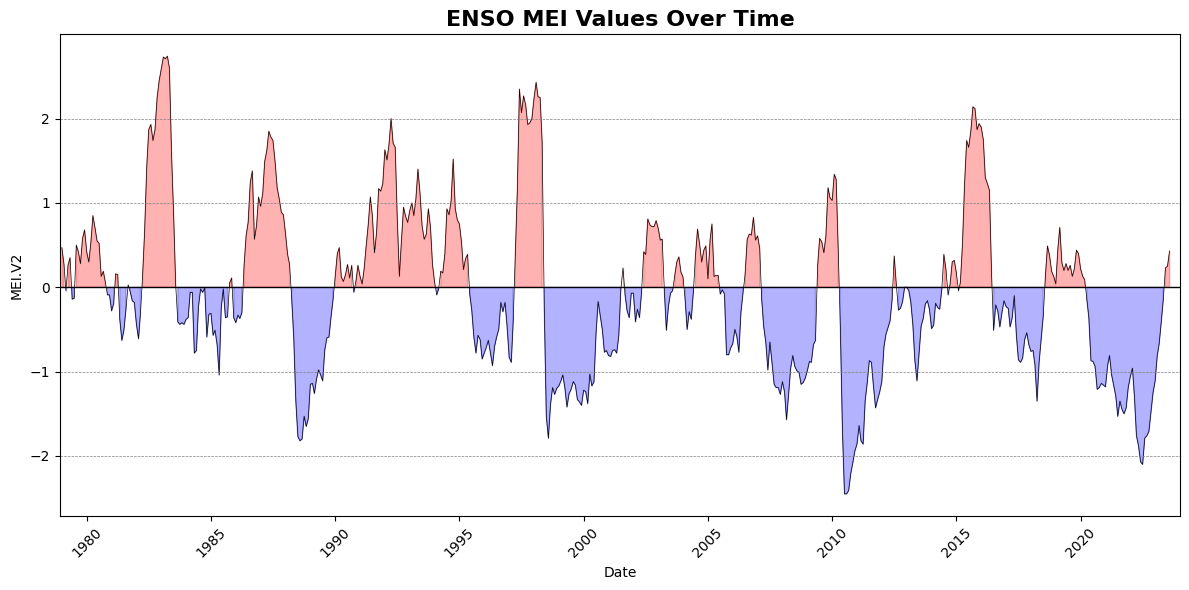

In [6]:
enso_mei_long = pd.read_csv('Data/enso_mei_long.csv')
# Combine the Year and Month columns to create a new Date column
enso_mei_long['Date'] = enso_mei_long['Year'].astype(str) + '-' + enso_mei_long['Month']
# Convert the new Date column to datetime format
enso_mei_long['Date'] = pd.to_datetime(enso_mei_long['Date'], format='%Y-%b')
#Plot the data
plt.figure(figsize=(12, 6))
plt.plot(enso_mei_long['Date'], enso_mei_long['MEI'], linestyle='-', color='black', linewidth=0.5)
#Only plot until 2024 x axis
plt.xlim(pd.Timestamp('1978-12-01'), pd.Timestamp('2024-01-01'))

plt.xlabel('Date')
plt.ylabel('MEI.V2')
#Create title, big font, bold
plt.title('ENSO MEI Values Over Time', fontsize=16, fontweight='bold')
plt.grid(False)
#Create dotted lines for El Nino and La Nina thresholds
plt.axhline(y=1, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=-1, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=2, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=-2, color='gray', linestyle='--', linewidth=0.5)
#grey background between 1 and -1
plt.axhspan(-1, 1, facecolor='white', alpha=0.2)
#Create thick solid line through 0
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
#Fill line above 0 with light red  
plt.fill_between(enso_mei_long['Date'], enso_mei_long['MEI'], where=enso_mei_long['MEI'] >= 0, color='red', alpha=0.3)
#Fill line below 0 with light blue
plt.fill_between(enso_mei_long['Date'], enso_mei_long['MEI'], where=enso_mei_long['MEI'] <= 0, color='blue', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
#Save plot in Plots folder with full quality
plt.savefig('Plots/enso_mei_long.png', dpi=300)

**Highlight El Niño highest cases**

In [8]:
#Highlight El Nino and La Nina periods
#Create empty list for El Nino and La Nina periods
el_nino = []
la_nina = []
#Loop through each row in the dataframe
for index, row in enso_mei_long.iterrows():
    #If MEI value is greater than 1, append the date to the El Nino list
    if row['MEI'] > 1:
        el_nino.append(enso_mei_long.loc[index, 'Date'])
    #If MEI value is less than -1, append the date to the La Nina list
    elif row['MEI'] < -1:
        la_nina.append(enso_mei_long.loc[index, 'Date'])
#Create a dataframe for El Nino and La Nina periods
el_nino = pd.DataFrame(el_nino, columns=['Date'])
la_nina = pd.DataFrame(la_nina, columns=['Date'])
#From data collect years which have continuous el nino or la nina periods
el_nino['Year'] = el_nino['Date'].dt.year
la_nina['Year'] = la_nina['Date'].dt.year
#Group by year and count the number of El Nino and La Nina periods
el_nino_grouped = el_nino.groupby('Year').count()
la_nina_grouped = la_nina.groupby('Year').count()

display(el_nino, el_nino_grouped)

,Date,Year
0,1982-06-01,1982
1,1982-07-01,1982
2,1982-08-01,1982
3,1982-09-01,1982
4,1982-10-01,1982
...,...,...
66,2016-01-01,2016
67,2016-02-01,2016
68,2016-03-01,2016
69,2016-04-01,2016


,Date
Year,
1982,7
1983,6
1986,3
1987,9
1991,4
1992,6
1993,3
1994,2
1997,8


# FEMA Natural Disasters Dataset

In [39]:
#Import data from CSV file
fema_disasters = pd.read_csv('Data/DisasterDeclarationsSummaries.csv')
#Quick view of data
display(fema_disasters.head())
# display(fema_disasters.dtypes)
# display(fema_disasters.describe())
#List all types of incidenType
display(fema_disasters['incidentType'].unique())

#From incidentType column, drop: 'Other', 'Human Cause', 'Terrorist' and 'Chemical' from the dataset
non_natural_disasters = ['Other', 'Human Cause', 'Terrorist', 'Chemical']
df_non_natural_disasters = 


,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,...,tribalRequest,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,lastIAFilingDate,lastRefresh,hash,id
0,FM-5465-NM,5465,NM,FM,2023-05-10T00:00:00.000Z,2023,Fire,LAS TUSAS FIRE,0,0,...,0,35,33,99033,Mora (County),23050,NaN,2023-05-22T03:41:22.800Z,56e2cdd7de53fd6bd0cbe22cd681d0d87708d0ac,e46df225-24a5-4178-9368-0f1c753f8748
1,FM-5465-NM,5465,NM,FM,2023-05-10T00:00:00.000Z,2023,Fire,LAS TUSAS FIRE,0,0,...,0,35,47,99047,San Miguel (County),23050,NaN,2023-05-22T03:41:22.800Z,33f747f70112aed4df749cfb1dd58f1d50f029ff,c8660535-8995-4187-af20-771b5669d4b7
2,FM-5464-RI,5464,RI,FM,2023-04-14T00:00:00.000Z,2023,Fire,QUEENS RIVER FIRE,0,0,...,0,44,9,99009,"Washington (County)(in (P)MSA 5520,6480)",23042,NaN,2023-05-22T03:41:22.800Z,1111d4d4a33f8a6e4d383ac5bd0e60b9bf142da0,9b9a9d9c-8b03-4049-9b16-a3c0d581556c
3,FM-5463-KS,5463,KS,FM,2023-04-13T00:00:00.000Z,2023,Fire,HADDAM FIRE,0,0,...,0,20,201,99201,Washington (County),23038,NaN,2023-05-22T03:41:22.800Z,78dd55a181f146622eb65835b5d794689d1ea7f2,57d936ce-a0d7-412a-9d78-18aee530c146
4,FM-5462-NE,5462,NE,FM,2023-04-09T00:00:00.000Z,2023,Fire,WACONDA-BEAVER LAKE FIRE COMPLEX,0,0,...,0,31,25,99025,Cass (County),23036,NaN,2023-05-22T03:41:22.800Z,5b35b5912f606a21ff29194317052ac7c2541be8,69325b2c-77cf-493f-8f1a-d5b5a737edf8


array(['Fire', 'Flood', 'Severe Storm', 'Winter Storm', 'Tornado',
       'Snowstorm', 'Earthquake', 'Biological', 'Hurricane',
       'Mud/Landslide', 'Coastal Storm', 'Other', 'Severe Ice Storm',
       'Dam/Levee Break', 'Tropical Storm', 'Typhoon',
       'Volcanic Eruption', 'Freezing', 'Toxic Substances', 'Chemical',
       'Terrorist', 'Drought', 'Human Cause', 'Fishing Losses', 'Tsunami'],
      dtype=object)

In [36]:
#Create dataset with one column representing all the unique fipsStateCode, another column representing he fipsCountyCode and the rest of the columns representing the years from 1953 to 2023. The values in the columns will be the number of disasters in that year for that state and county.
#Create empty dataframe
fema_disasters_long = pd.DataFrame()
#Create empty lists for state, county, and year
state = []
county = []
year = []
state_name = []
#Loop through each row in the dataframe
for index, row in fema_disasters.iterrows():
    #Append the state, county, and year to the corresponding list
    state.append(row['fipsStateCode'])
    state_name.append(row['state'])
    county.append(row['fipsCountyCode'])
    year.append(row['fyDeclared'])
#Add the lists to the dataframe
fema_disasters_long['StateCode'] = state
fema_disasters_long['State'] = state_name
fema_disasters_long['CountyCode'] = county
fema_disasters_long['Year'] = year
#Group by state, county, and year and count the number of disasters
fema_disasters_long = fema_disasters_long.groupby(['State', 'CountyCode', 'Year']).size().reset_index(name='Disasters')
#Create a pivot table with state and county as the index, year as the columns, and disasters as the values
fema_disasters_long = fema_disasters_long.pivot_table(index=['State', 'CountyCode'], columns='Year', values='Disasters')
#Fill NaN values with 0
fema_disasters_long = fema_disasters_long.fillna(0)

display(fema_disasters_long.head(40))



Year              1953  1954  1955  1956  1957  1958  1959  1960  1961  1962   
State CountyCode                                                               
AK    0            0.0   1.0   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  \
      13           0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
      16           0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
      20           0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
      50           0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
      60           0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
      68           0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
      70           0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
      90           0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
      100          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
      105          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
      110          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
      122          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
      130          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
      150          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
      158          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
      164          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
      170          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
      180          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
      185          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
      188          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
      195          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
      198          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
      201          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
      220          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
      230          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
      240          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
      261          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
      270          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
      275          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
      280          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
      282          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
      290          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
AL    0            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   
      1            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
      3            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
      5            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
      7            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
      9            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
      11           0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

Year              ...  2014  2015  2016  2017  2018  2019  2020  2021  2022   
State CountyCode  ...                                                         
AK    0           ...   0.0   0.0   0.0   0.0   0.0   0.0  25.0   0.0   0.0  \
      13          ...   0.0   0.0   0.0   0.0   0.0   0.0   3.0   0.0   0.0   
      16          ...   0.0   0.0   1.0   0.0   0.0   0.0   6.0   0.0   1.0   
      20          ...   0.0   0.0   0.0   0.0   0.0   2.0   2.0   0.0   0.0   
      50          ...   2.0   0.0   0.0   0.0   0.0   0.0  11.0   0.0   4.0   
      60          ...   0.0   0.0   0.0   0.0   0.0   0.0   2.0   0.0   0.0   
      6